In [ ]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 512
epochs = 200
sample_size = 64
nz = 128
k = 1

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)), # 데이터 전처리 과정 / 입력 이미지 정규화
])

train_dataset = datasets.MNIST( # MNIST 데이터셋 불러옴
    root="./data", train=True, transform=transform, download=True) # Train=True : 훈련 데이터셋

train_loader = DataLoader( # 배치 단위로 데이터 로드
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) # batch_six : 한 번에 512개 가져옴
                                                                       # Shuffle=True : 데이터 순서 섞어서 로드 -> 다양성 증가

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.62MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 생성자 구현
class Generator(nn.Module):
    def __init__(self, nz): # 생성자 : 랜덤 노이즈 z를 입력값으로
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential( # 신경망 구조
            nn.Linear(self.nz, 256), # 완전 연결층
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784), # 최종적으로 784차원
            nn.Tanh(),
        )
    def forward(self, x): # 순전파 / x : 랜덤 노이즈 입력값
        return self.main(x).view(-1, 1, 28, 28)

In [ ]:
# 판별자 구현
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1), # 최종 출려값 / 0~1 사이의 확률값
            nn.Sigmoid(), # 최종 출력값을 [0, 1] 범위로 조정시킴
        )
    def forward(self, x): # 순전파
        x = x.view(-1, 784) # 배치 크기를 맞춰주는 형태
        return self.main(x)

In [ ]:
# 생성자와 판별자 초기화
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [ ]:
# 옵티마이저와 손실함수 정의
optim_g = optim.Adam(generator.parameters(), lr=0.0002) # Adam 옵티마이저로 생성자 각각 최적화시킴
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002) # Adam 옵티마이저로 판별자 각각 최적화시킴

criterion = nn.BCELoss() # 손실 함수(Binary Cross Entropy Loss -> 이진 분류 대상)

# 손실값 / 생성된 이미지 저장시킬 공간
losses_g = []
losses_d = []
images = []

In [ ]:
# 생성된 이미지 저장 함수 정의
def save_generator_image(image, path): # 생성된 이미지를 path에 저장
    save_image(image, path)

In [ ]:
# 판별자 학습을 위한 함수
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device) # 진짜 이미지 : 1로 라벨링
    fake_label = torch.zeros(b_size, 1).to(device) # 가짜 이미지 : 0으로 라벨링
    optimizer.zero_grad() # 역전파로 인해 그래디언트 누적되는 것 초기화 필요

    # 진짜 데이터 학습
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label) # 진짜 데이터를 판별자로 학습한 결과와 진짜 레이블 간의 오차값 계산
    # 가짜 데이터 학습
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label) # 가짜 데이터로 판별자로 학습한 결과와 가짜 레이블 간의 오차값 계산

    loss_real.backward()
    loss_fake.backward()
    optimizer.step() # 옵티마이저(가중치) 업데이트시킴
    return loss_real + loss_fake # 진짜 데이터와 가짜 데이터의 오차를 합한 최종적인 오차 형태

In [ ]:
# 생성자 학습을 위한 함수
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device) # 가짜 데이터를 1로 라벨링
    optimizer.zero_grad() # 그래디언트 누적되는 거 방지

    output = discriminator(data_fake) # 가짜 데이터만 활용함 -> 가짜 데이터 입력받아 진짜일 확률
    loss = criterion(output, real_label) # 손실값 계산

    loss.backward()
    optimizer.step()

    return loss # 최종 손실값

In [ ]:
!mkdir img #img 폴더 만들기

In [ ]:
# 모델 학습 과정
# 학습 모드 설정
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0 # 변수 초기값 0으로
    loss_d = 0.0
    # 데이터 로더를 통한 배치 학습
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):

        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # 판별자 학습 과정
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach() # 생성자에서 노이즈 입력받아 가짜 이미지 생성
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        # 생성자 학습 과정
        data_fake = generator(torch.randn(b_size, nz).to(device)) # 새로운 가짜 이미지 생성
        loss_g += train_generator(optim_g, data_fake)
    # 이미지 생성 및 저장
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, "./img/gen_img{epoch}.png")
    images.append(generated_img)
    # 손실값 계산, 저장
    epoch_loss_g = loss_g / idx # 평균 생성자 손실
    epoch_loss_d = loss_d / idx # 평균 판별자 손실
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:11, 10.12it/s]                         

Epoch 0 of 200
Generator loss: 1.32567739, Discriminator loss: 0.89297736



118it [00:11, 10.34it/s]                         


Epoch 1 of 200
Generator loss: 1.81906307, Discriminator loss: 1.40885425


118it [00:11, 10.40it/s]                         

Epoch 2 of 200
Generator loss: 2.98218799, Discriminator loss: 0.89903188



118it [00:11,  9.93it/s]                         

Epoch 3 of 200
Generator loss: 0.99073362, Discriminator loss: 1.27104998



118it [00:10, 10.74it/s]                         

Epoch 4 of 200
Generator loss: 1.19823217, Discriminator loss: 1.23320830



118it [00:10, 10.83it/s]                         


Epoch 5 of 200
Generator loss: 5.84866238, Discriminator loss: 0.73695904


118it [00:11, 10.28it/s]                         

Epoch 6 of 200
Generator loss: 2.29009056, Discriminator loss: 1.09637702



118it [00:12,  9.48it/s]                         

Epoch 7 of 200
Generator loss: 1.39046371, Discriminator loss: 1.20699978



118it [00:12,  9.28it/s]                         

Epoch 8 of 200
Generator loss: 0.95712346, Discriminator loss: 1.21664739



118it [00:11,  9.98it/s]                         

Epoch 9 of 200
Generator loss: 1.29846108, Discriminator loss: 1.12485468



118it [00:11, 10.03it/s]                         

Epoch 10 of 200
Generator loss: 2.37614441, Discriminator loss: 1.32535195



118it [00:12,  9.27it/s]                         

Epoch 11 of 200
Generator loss: 2.22657204, Discriminator loss: 1.10863245



118it [00:15,  7.82it/s]                         

Epoch 12 of 200
Generator loss: 2.21962047, Discriminator loss: 0.98221207



118it [00:15,  7.54it/s]

Epoch 13 of 200
Generator loss: 1.37022293, Discriminator loss: 1.21424878



118it [00:16,  7.33it/s]

Epoch 14 of 200
Generator loss: 2.48201084, Discriminator loss: 0.96542794



118it [00:13,  8.73it/s]                         

Epoch 15 of 200
Generator loss: 1.64164126, Discriminator loss: 1.27583766



118it [00:13,  8.56it/s]                         

Epoch 16 of 200
Generator loss: 1.73654532, Discriminator loss: 0.82898736



118it [00:12,  9.34it/s]                         

Epoch 17 of 200
Generator loss: 1.90745056, Discriminator loss: 1.06243026



118it [00:12,  9.71it/s]                         

Epoch 18 of 200
Generator loss: 1.37720239, Discriminator loss: 0.99094069



118it [00:11, 10.10it/s]                         

Epoch 19 of 200
Generator loss: 1.84554291, Discriminator loss: 0.90686882



118it [00:12,  9.70it/s]                         

Epoch 20 of 200
Generator loss: 2.09504676, Discriminator loss: 0.80842036



118it [00:11, 10.07it/s]                         

Epoch 21 of 200
Generator loss: 1.76052237, Discriminator loss: 0.85557067



118it [00:12,  9.44it/s]                         

Epoch 22 of 200
Generator loss: 1.73394680, Discriminator loss: 0.81417131



118it [00:13,  8.75it/s]                         

Epoch 23 of 200
Generator loss: 1.68064630, Discriminator loss: 0.66546869



118it [00:17,  6.74it/s]                         

Epoch 24 of 200
Generator loss: 2.86298060, Discriminator loss: 0.41476771



118it [00:13,  8.45it/s]                         

Epoch 25 of 200
Generator loss: 2.79871726, Discriminator loss: 0.43197578



118it [00:12,  9.46it/s]                         

Epoch 26 of 200
Generator loss: 2.90822506, Discriminator loss: 0.52611870



118it [00:14,  8.40it/s]                         

Epoch 27 of 200
Generator loss: 2.82330251, Discriminator loss: 0.50895339



118it [00:15,  7.85it/s]


Epoch 28 of 200
Generator loss: 2.80139470, Discriminator loss: 0.41884279


118it [00:14,  8.04it/s]                         

Epoch 29 of 200
Generator loss: 2.68260098, Discriminator loss: 0.48754707



118it [00:12,  9.21it/s]                         


Epoch 30 of 200
Generator loss: 2.87278056, Discriminator loss: 0.50771475


118it [00:12,  9.67it/s]                         


Epoch 31 of 200
Generator loss: 2.50462246, Discriminator loss: 0.62507683


118it [00:12,  9.75it/s]                         


Epoch 32 of 200
Generator loss: 2.71780825, Discriminator loss: 0.48903617


118it [00:12,  9.26it/s]                         

Epoch 33 of 200
Generator loss: 2.87111735, Discriminator loss: 0.45086634



118it [00:11, 10.17it/s]                         

Epoch 34 of 200
Generator loss: 2.60673094, Discriminator loss: 0.56243867



118it [00:11,  9.90it/s]                         

Epoch 35 of 200
Generator loss: 2.72606611, Discriminator loss: 0.48686403



118it [00:11, 10.23it/s]                         

Epoch 36 of 200
Generator loss: 2.47100019, Discriminator loss: 0.57838023



118it [00:11, 10.65it/s]                         


Epoch 37 of 200
Generator loss: 2.39085007, Discriminator loss: 0.59721112


118it [00:11, 10.42it/s]                         

Epoch 38 of 200
Generator loss: 2.49324346, Discriminator loss: 0.59251666



118it [00:11,  9.85it/s]                         


Epoch 39 of 200
Generator loss: 2.77208519, Discriminator loss: 0.52435648


118it [00:11,  9.84it/s]                         

Epoch 40 of 200
Generator loss: 2.72151494, Discriminator loss: 0.49843580



118it [00:11, 10.13it/s]                         

Epoch 41 of 200
Generator loss: 3.20776391, Discriminator loss: 0.45417157



118it [00:11, 10.21it/s]                         


Epoch 42 of 200
Generator loss: 2.61140418, Discriminator loss: 0.58320612


118it [00:11,  9.94it/s]                         

Epoch 43 of 200
Generator loss: 2.88725424, Discriminator loss: 0.46648160



118it [00:12,  9.80it/s]                         

Epoch 44 of 200
Generator loss: 2.78161263, Discriminator loss: 0.55577105



118it [00:11,  9.99it/s]                         

Epoch 45 of 200
Generator loss: 2.80674529, Discriminator loss: 0.50223559



118it [00:11, 10.02it/s]                         

Epoch 46 of 200
Generator loss: 2.73027992, Discriminator loss: 0.58779246



118it [00:11, 10.00it/s]                         

Epoch 47 of 200
Generator loss: 2.82924938, Discriminator loss: 0.55714184



118it [00:11, 10.18it/s]                         

Epoch 48 of 200
Generator loss: 2.63843250, Discriminator loss: 0.59289247



118it [00:11, 10.16it/s]                         

Epoch 49 of 200
Generator loss: 2.49905062, Discriminator loss: 0.56485540



118it [00:11, 10.24it/s]                         

Epoch 50 of 200
Generator loss: 2.71616864, Discriminator loss: 0.54764915



118it [00:10, 10.74it/s]                         

Epoch 51 of 200
Generator loss: 2.54708719, Discriminator loss: 0.57573181



118it [00:10, 10.76it/s]                         


Epoch 52 of 200
Generator loss: 2.53037000, Discriminator loss: 0.56593019


118it [00:11, 10.27it/s]                         


Epoch 53 of 200
Generator loss: 2.71340275, Discriminator loss: 0.56349069


118it [00:11, 10.20it/s]                         

Epoch 54 of 200
Generator loss: 2.74932933, Discriminator loss: 0.52627617



118it [00:11, 10.34it/s]                         

Epoch 55 of 200
Generator loss: 2.93026924, Discriminator loss: 0.53632200



118it [00:11, 10.29it/s]                         

Epoch 56 of 200
Generator loss: 2.74366164, Discriminator loss: 0.58227521



118it [00:11, 10.12it/s]                         


Epoch 57 of 200
Generator loss: 2.54867625, Discriminator loss: 0.59554553


118it [00:11, 10.21it/s]                         

Epoch 58 of 200
Generator loss: 2.60908508, Discriminator loss: 0.56018990



118it [00:11, 10.26it/s]                         

Epoch 59 of 200
Generator loss: 2.63971090, Discriminator loss: 0.55733865



118it [00:11, 10.13it/s]                         

Epoch 60 of 200
Generator loss: 2.54629970, Discriminator loss: 0.59494835



118it [00:11, 10.26it/s]                         

Epoch 61 of 200
Generator loss: 2.35659933, Discriminator loss: 0.65221256



118it [00:11, 10.07it/s]                         

Epoch 62 of 200
Generator loss: 2.47694468, Discriminator loss: 0.64542454



118it [00:11, 10.54it/s]                         

Epoch 63 of 200
Generator loss: 2.57946682, Discriminator loss: 0.62748182



118it [00:10, 10.77it/s]                         

Epoch 64 of 200
Generator loss: 2.46568942, Discriminator loss: 0.60189277



118it [00:11, 10.47it/s]                         


Epoch 65 of 200
Generator loss: 2.53585315, Discriminator loss: 0.56897902


118it [00:11, 10.13it/s]                         


Epoch 66 of 200
Generator loss: 2.38424373, Discriminator loss: 0.60903370


118it [00:11, 10.36it/s]                         

Epoch 67 of 200
Generator loss: 2.41216946, Discriminator loss: 0.60548836



118it [00:11, 10.22it/s]                         

Epoch 68 of 200
Generator loss: 2.37942696, Discriminator loss: 0.63168132



118it [00:11, 10.30it/s]                         


Epoch 69 of 200
Generator loss: 2.43456697, Discriminator loss: 0.62013787


118it [00:11, 10.10it/s]                         

Epoch 70 of 200
Generator loss: 2.54953885, Discriminator loss: 0.58190066



118it [00:11, 10.20it/s]                         

Epoch 71 of 200
Generator loss: 2.52217603, Discriminator loss: 0.62444770



118it [00:11, 10.23it/s]                         

Epoch 72 of 200
Generator loss: 2.41615677, Discriminator loss: 0.63979429



118it [00:11, 10.24it/s]                         

Epoch 73 of 200
Generator loss: 2.49415994, Discriminator loss: 0.62534922



118it [00:11, 10.28it/s]                         

Epoch 74 of 200
Generator loss: 2.37766767, Discriminator loss: 0.60533553



118it [00:11, 10.70it/s]                         

Epoch 75 of 200
Generator loss: 2.55353379, Discriminator loss: 0.59618467



118it [00:10, 10.96it/s]                         

Epoch 76 of 200
Generator loss: 2.32213020, Discriminator loss: 0.65977091



118it [00:11, 10.08it/s]                         

Epoch 77 of 200
Generator loss: 2.25355148, Discriminator loss: 0.66756409



118it [00:11, 10.20it/s]                         

Epoch 78 of 200
Generator loss: 2.25245619, Discriminator loss: 0.67457038



118it [00:11, 10.27it/s]                         

Epoch 79 of 200
Generator loss: 2.26080322, Discriminator loss: 0.66919589



118it [00:11, 10.35it/s]                         

Epoch 80 of 200
Generator loss: 2.24574804, Discriminator loss: 0.65720856



118it [00:11, 10.22it/s]                         

Epoch 81 of 200
Generator loss: 2.25876093, Discriminator loss: 0.65977830



118it [00:11, 10.44it/s]                         

Epoch 82 of 200
Generator loss: 2.19318509, Discriminator loss: 0.69790792



118it [00:11, 10.20it/s]                         

Epoch 83 of 200
Generator loss: 2.29965520, Discriminator loss: 0.70660818



118it [00:11, 10.20it/s]                         

Epoch 84 of 200
Generator loss: 2.04727006, Discriminator loss: 0.71201539



118it [00:11, 10.32it/s]                         


Epoch 85 of 200
Generator loss: 2.14577007, Discriminator loss: 0.71059954


118it [00:11, 10.60it/s]                         


Epoch 86 of 200
Generator loss: 2.06602716, Discriminator loss: 0.72184622


118it [00:10, 10.90it/s]                         

Epoch 87 of 200
Generator loss: 2.17614508, Discriminator loss: 0.73461807



118it [00:11, 10.43it/s]                         

Epoch 88 of 200
Generator loss: 1.89780819, Discriminator loss: 0.80027539



118it [00:11, 10.10it/s]                         

Epoch 89 of 200
Generator loss: 2.06167722, Discriminator loss: 0.74042189



118it [00:11, 10.37it/s]                         

Epoch 90 of 200
Generator loss: 1.96201050, Discriminator loss: 0.77644247



118it [00:11, 10.23it/s]                         

Epoch 91 of 200
Generator loss: 1.95311403, Discriminator loss: 0.79222775



118it [00:11, 10.23it/s]                         

Epoch 92 of 200
Generator loss: 1.93588245, Discriminator loss: 0.82063335



118it [00:11, 10.47it/s]                         

Epoch 93 of 200
Generator loss: 2.04621410, Discriminator loss: 0.74908108



118it [00:11, 10.23it/s]                         

Epoch 94 of 200
Generator loss: 1.99234223, Discriminator loss: 0.76672190



118it [00:11, 10.48it/s]                         

Epoch 95 of 200
Generator loss: 2.04735065, Discriminator loss: 0.74234515



118it [00:11, 10.57it/s]                         

Epoch 96 of 200
Generator loss: 1.99242187, Discriminator loss: 0.77011514



118it [00:11, 10.62it/s]                         

Epoch 97 of 200
Generator loss: 1.90643024, Discriminator loss: 0.78319067



118it [00:10, 10.91it/s]                         

Epoch 98 of 200
Generator loss: 1.99560320, Discriminator loss: 0.75599015



118it [00:11, 10.32it/s]

Epoch 99 of 200
Generator loss: 1.87133574, Discriminator loss: 0.80905414



118it [00:11, 10.26it/s]                         

Epoch 100 of 200
Generator loss: 1.86261368, Discriminator loss: 0.81689990



118it [00:11, 10.40it/s]                         

Epoch 101 of 200
Generator loss: 2.02367544, Discriminator loss: 0.77898991



118it [00:11, 10.29it/s]                         

Epoch 102 of 200
Generator loss: 1.87489796, Discriminator loss: 0.80290347



118it [00:11, 10.27it/s]                         

Epoch 103 of 200
Generator loss: 1.93321443, Discriminator loss: 0.78784132



118it [00:11, 10.31it/s]                         

Epoch 104 of 200
Generator loss: 1.93428886, Discriminator loss: 0.80619758



118it [00:11, 10.26it/s]                         

Epoch 105 of 200
Generator loss: 1.95432353, Discriminator loss: 0.79433626



118it [00:11, 10.37it/s]                         

Epoch 106 of 200
Generator loss: 1.91093671, Discriminator loss: 0.80188334



118it [00:11, 10.39it/s]                         

Epoch 107 of 200
Generator loss: 1.82997024, Discriminator loss: 0.83253455



118it [00:11, 10.49it/s]                         

Epoch 108 of 200
Generator loss: 1.77177441, Discriminator loss: 0.86950421



118it [00:12,  9.73it/s]                         

Epoch 109 of 200
Generator loss: 1.79875922, Discriminator loss: 0.83088624



118it [00:11, 10.18it/s]                         

Epoch 110 of 200
Generator loss: 1.79196858, Discriminator loss: 0.83917665



118it [00:11, 10.32it/s]                         

Epoch 111 of 200
Generator loss: 1.78018939, Discriminator loss: 0.83793616



118it [00:11,  9.90it/s]

Epoch 112 of 200
Generator loss: 1.74182773, Discriminator loss: 0.85469168



118it [00:11, 10.25it/s]                         

Epoch 113 of 200
Generator loss: 1.73252833, Discriminator loss: 0.88141078



118it [00:11, 10.22it/s]                         

Epoch 114 of 200
Generator loss: 1.73637152, Discriminator loss: 0.86646068



118it [00:11, 10.28it/s]                         

Epoch 115 of 200
Generator loss: 1.72074997, Discriminator loss: 0.85908377



118it [00:11, 10.37it/s]                         

Epoch 116 of 200
Generator loss: 1.72969079, Discriminator loss: 0.88703346



118it [00:11, 10.39it/s]                         

Epoch 117 of 200
Generator loss: 1.70025659, Discriminator loss: 0.89375520



118it [00:11, 10.20it/s]                         

Epoch 118 of 200
Generator loss: 1.70989668, Discriminator loss: 0.88180989



118it [00:11, 10.56it/s]                         

Epoch 119 of 200
Generator loss: 1.77817631, Discriminator loss: 0.84691077



118it [00:11, 10.65it/s]                         

Epoch 120 of 200
Generator loss: 1.75112629, Discriminator loss: 0.86999756



118it [00:10, 11.23it/s]                         

Epoch 121 of 200
Generator loss: 1.67756402, Discriminator loss: 0.87087286



118it [00:10, 10.86it/s]                         

Epoch 122 of 200
Generator loss: 1.70709932, Discriminator loss: 0.86859149



118it [00:11, 10.45it/s]                         

Epoch 123 of 200
Generator loss: 1.64957070, Discriminator loss: 0.90697527



118it [00:11, 10.57it/s]                         

Epoch 124 of 200
Generator loss: 1.68179095, Discriminator loss: 0.87708265



118it [00:11, 10.29it/s]                         

Epoch 125 of 200
Generator loss: 1.70499289, Discriminator loss: 0.87598836



118it [00:11, 10.39it/s]                         

Epoch 126 of 200
Generator loss: 1.62899852, Discriminator loss: 0.89823014



118it [00:11, 10.57it/s]                         

Epoch 127 of 200
Generator loss: 1.66131568, Discriminator loss: 0.90353292



118it [00:11, 10.35it/s]                         

Epoch 128 of 200
Generator loss: 1.59654105, Discriminator loss: 0.90790594



118it [00:11, 10.51it/s]                         

Epoch 129 of 200
Generator loss: 1.64014935, Discriminator loss: 0.90598696



118it [00:10, 10.92it/s]

Epoch 130 of 200
Generator loss: 1.62341595, Discriminator loss: 0.93033218



118it [00:10, 11.04it/s]                         

Epoch 131 of 200
Generator loss: 1.52658820, Discriminator loss: 0.92878079



118it [00:11, 10.55it/s]                         

Epoch 132 of 200
Generator loss: 1.59557843, Discriminator loss: 0.94885522



118it [00:11, 10.56it/s]                         

Epoch 133 of 200
Generator loss: 1.61600387, Discriminator loss: 0.95127863



118it [00:11, 10.45it/s]                         

Epoch 134 of 200
Generator loss: 1.51733339, Discriminator loss: 0.94042253



118it [00:11, 10.57it/s]                         

Epoch 135 of 200
Generator loss: 1.61004150, Discriminator loss: 0.92035669



118it [00:11, 10.40it/s]                         

Epoch 136 of 200
Generator loss: 1.63009858, Discriminator loss: 0.92584401



118it [00:11, 10.58it/s]                         

Epoch 137 of 200
Generator loss: 1.57240319, Discriminator loss: 0.93528181



118it [00:11, 10.57it/s]                         

Epoch 138 of 200
Generator loss: 1.56111705, Discriminator loss: 0.94172347



118it [00:10, 10.84it/s]                         

Epoch 139 of 200
Generator loss: 1.51411390, Discriminator loss: 0.97362250



118it [00:10, 11.44it/s]

Epoch 140 of 200
Generator loss: 1.53316200, Discriminator loss: 0.94756734



118it [00:11, 10.67it/s]                         

Epoch 141 of 200
Generator loss: 1.57365775, Discriminator loss: 0.93458903



118it [00:11, 10.37it/s]                         

Epoch 142 of 200
Generator loss: 1.47939885, Discriminator loss: 0.96733779



118it [00:11, 10.52it/s]                         

Epoch 143 of 200
Generator loss: 1.48180473, Discriminator loss: 0.96654785



118it [00:11, 10.39it/s]                         

Epoch 144 of 200
Generator loss: 1.50286686, Discriminator loss: 0.97822261



118it [00:11, 10.19it/s]                         

Epoch 145 of 200
Generator loss: 1.48897183, Discriminator loss: 0.97981960



118it [00:11, 10.23it/s]                         

Epoch 146 of 200
Generator loss: 1.45081103, Discriminator loss: 0.98608994



118it [00:11, 10.30it/s]

Epoch 147 of 200
Generator loss: 1.51418734, Discriminator loss: 0.96853906



118it [00:11, 10.37it/s]                         

Epoch 148 of 200
Generator loss: 1.45424795, Discriminator loss: 0.98194629



118it [00:11, 10.71it/s]

Epoch 149 of 200
Generator loss: 1.51593065, Discriminator loss: 0.96756679



118it [00:10, 10.99it/s]                         

Epoch 150 of 200
Generator loss: 1.42355657, Discriminator loss: 0.99802333



118it [00:10, 10.74it/s]                         

Epoch 151 of 200
Generator loss: 1.46246099, Discriminator loss: 0.98738486



118it [00:11, 10.27it/s]                         

Epoch 152 of 200
Generator loss: 1.45170569, Discriminator loss: 0.98734236



118it [00:11, 10.34it/s]                         

Epoch 153 of 200
Generator loss: 1.52117479, Discriminator loss: 0.97317934



118it [00:11, 10.43it/s]                         

Epoch 154 of 200
Generator loss: 1.48806703, Discriminator loss: 0.97763038



118it [00:11, 10.49it/s]                         

Epoch 155 of 200
Generator loss: 1.43057394, Discriminator loss: 1.00096810



118it [00:11, 10.63it/s]                         

Epoch 156 of 200
Generator loss: 1.39230037, Discriminator loss: 1.01808488



118it [00:11, 10.52it/s]                         

Epoch 157 of 200
Generator loss: 1.42318952, Discriminator loss: 0.99049479



118it [00:11, 10.41it/s]                         

Epoch 158 of 200
Generator loss: 1.39990592, Discriminator loss: 1.00385952



118it [00:11, 10.67it/s]                         


Epoch 159 of 200
Generator loss: 1.41793990, Discriminator loss: 1.00829387


118it [00:10, 11.33it/s]                         

Epoch 160 of 200
Generator loss: 1.42694986, Discriminator loss: 1.00724351



118it [00:11, 10.65it/s]                         

Epoch 161 of 200
Generator loss: 1.44457459, Discriminator loss: 1.01667619



118it [00:11, 10.58it/s]                         

Epoch 162 of 200
Generator loss: 1.33494055, Discriminator loss: 1.02005851



118it [00:11, 10.24it/s]                         

Epoch 163 of 200
Generator loss: 1.42858934, Discriminator loss: 1.01343703



118it [00:11, 10.30it/s]                         

Epoch 164 of 200
Generator loss: 1.36642289, Discriminator loss: 1.02905667



118it [00:11, 10.23it/s]

Epoch 165 of 200
Generator loss: 1.41377592, Discriminator loss: 1.01704240



118it [00:11,  9.99it/s]                         

Epoch 166 of 200
Generator loss: 1.32627714, Discriminator loss: 1.04590845



118it [00:11, 10.20it/s]                         

Epoch 167 of 200
Generator loss: 1.36702108, Discriminator loss: 1.02038288



118it [00:11, 10.30it/s]                         

Epoch 168 of 200
Generator loss: 1.38256872, Discriminator loss: 1.03340697



118it [00:11, 10.12it/s]                         

Epoch 169 of 200
Generator loss: 1.38219035, Discriminator loss: 1.02479422



118it [00:11, 10.61it/s]                         

Epoch 170 of 200
Generator loss: 1.36327648, Discriminator loss: 1.04935586



118it [00:11, 10.67it/s]                         


Epoch 171 of 200
Generator loss: 1.34384668, Discriminator loss: 1.04554379


118it [00:11, 10.53it/s]

Epoch 172 of 200
Generator loss: 1.37582767, Discriminator loss: 1.03902602



118it [00:11, 10.18it/s]                         

Epoch 173 of 200
Generator loss: 1.37434578, Discriminator loss: 1.02813423



118it [00:11, 10.26it/s]                         

Epoch 174 of 200
Generator loss: 1.33410490, Discriminator loss: 1.04034603



118it [00:11, 10.29it/s]                         

Epoch 175 of 200
Generator loss: 1.32900953, Discriminator loss: 1.05021000



118it [00:11,  9.99it/s]                         

Epoch 176 of 200
Generator loss: 1.33723915, Discriminator loss: 1.03039324



118it [00:11, 10.08it/s]

Epoch 177 of 200
Generator loss: 1.35869431, Discriminator loss: 1.04652035



118it [00:11, 10.11it/s]                         

Epoch 178 of 200
Generator loss: 1.35981846, Discriminator loss: 1.04756761



118it [00:11, 10.13it/s]                         

Epoch 179 of 200
Generator loss: 1.29910958, Discriminator loss: 1.05012131



118it [00:11, 10.22it/s]                         

Epoch 180 of 200
Generator loss: 1.32560933, Discriminator loss: 1.04056823



118it [00:11, 10.23it/s]                         

Epoch 181 of 200
Generator loss: 1.33156633, Discriminator loss: 1.04021955



118it [00:11, 10.50it/s]                         

Epoch 182 of 200
Generator loss: 1.34438097, Discriminator loss: 1.05450165



118it [00:11, 10.55it/s]                         


Epoch 183 of 200
Generator loss: 1.33982205, Discriminator loss: 1.04936612


118it [00:11, 10.40it/s]                         

Epoch 184 of 200
Generator loss: 1.30753136, Discriminator loss: 1.06253910



118it [00:11, 10.15it/s]                         

Epoch 185 of 200
Generator loss: 1.31248510, Discriminator loss: 1.06933427



118it [00:11, 10.06it/s]                         


Epoch 186 of 200
Generator loss: 1.35451901, Discriminator loss: 1.04572809


118it [00:11, 10.11it/s]                         

Epoch 187 of 200
Generator loss: 1.33296824, Discriminator loss: 1.04431617



118it [00:11, 10.19it/s]                         

Epoch 188 of 200
Generator loss: 1.29335737, Discriminator loss: 1.06013656



118it [00:11, 10.09it/s]

Epoch 189 of 200
Generator loss: 1.33506393, Discriminator loss: 1.05652714



118it [00:11, 10.20it/s]                         

Epoch 190 of 200
Generator loss: 1.30993545, Discriminator loss: 1.06191039



118it [00:11, 10.18it/s]                         

Epoch 191 of 200
Generator loss: 1.26734614, Discriminator loss: 1.08963454



118it [00:11, 10.16it/s]                         

Epoch 192 of 200
Generator loss: 1.27493382, Discriminator loss: 1.07089877



118it [00:11, 10.21it/s]                         

Epoch 193 of 200
Generator loss: 1.23961008, Discriminator loss: 1.09355330



118it [00:11, 10.36it/s]                         

Epoch 194 of 200
Generator loss: 1.26372480, Discriminator loss: 1.07568264



118it [00:10, 10.87it/s]                         

Epoch 195 of 200
Generator loss: 1.22939885, Discriminator loss: 1.08214593



118it [00:11, 10.53it/s]                         

Epoch 196 of 200
Generator loss: 1.26858163, Discriminator loss: 1.09257996



118it [00:11, 10.19it/s]                         

Epoch 197 of 200
Generator loss: 1.26305342, Discriminator loss: 1.09270954



118it [00:11, 10.16it/s]                         

Epoch 198 of 200
Generator loss: 1.23326850, Discriminator loss: 1.08909440



118it [00:11, 10.16it/s]                         


Epoch 199 of 200
Generator loss: 1.20165300, Discriminator loss: 1.10178363


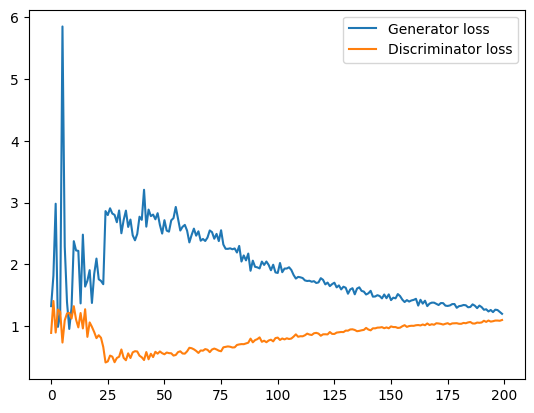

In [ ]:
# 생성자와 판별자의 오차값 확인
plt.figure()
losses_g = [fl.item() for fl in losses_g] # 파이썬 숫자값으로 변환
plt.plot(losses_g, label = 'Generator loss')
losses_d = [fl.item() for fl in losses_d]
plt.plot(losses_d, label = 'Discriminator loss')
plt.legend()

In [ ]:
import numpy as np

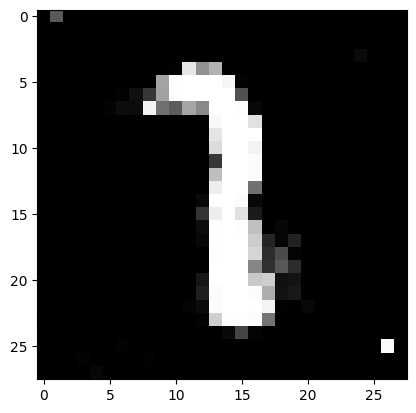

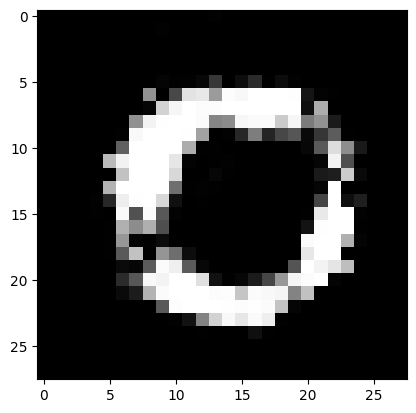

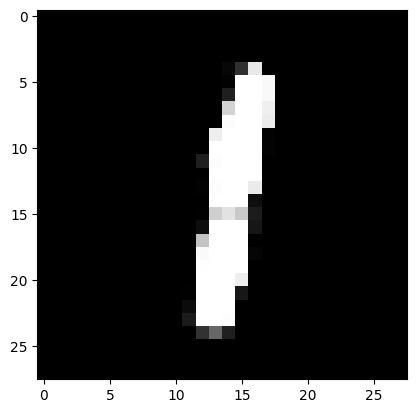

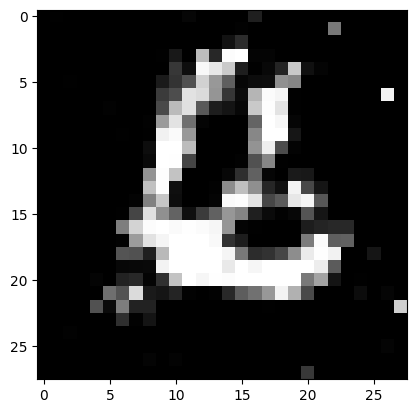

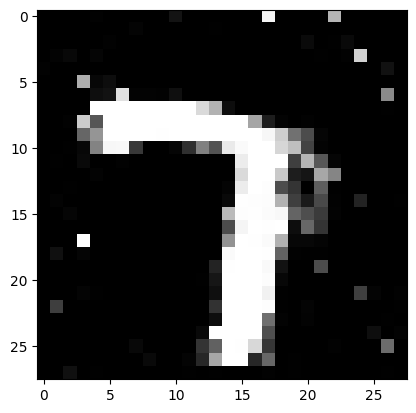

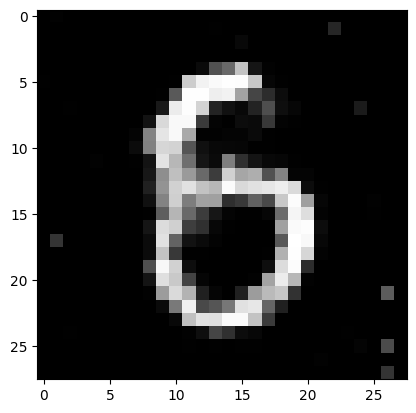

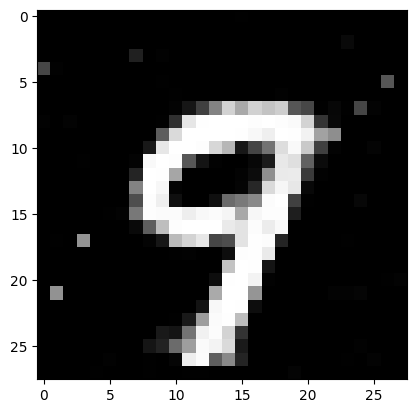

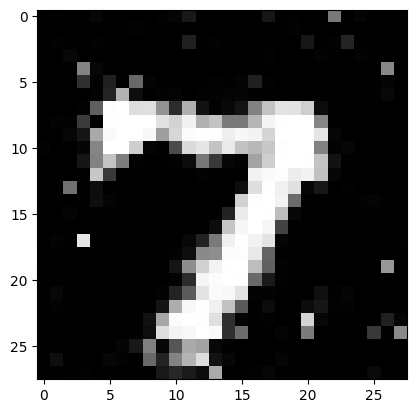

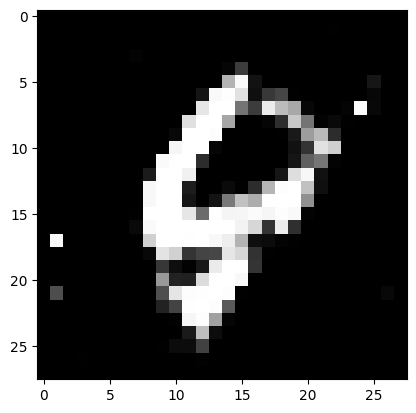

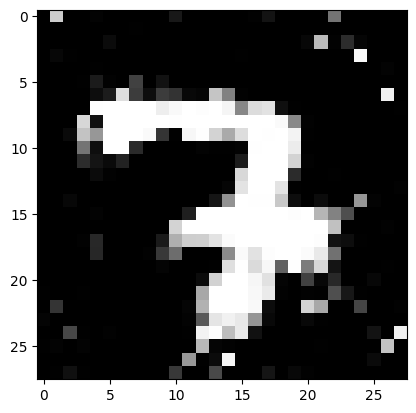

In [ ]:
# 생성된 이미지 일부만 출력
fake_images = generator(torch.randn(sample_size, nz).to(device))
for i in range(10): # 생성된 이미지 10개 출력
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28)) # Numpy 배열로 변환
  plt.imshow(fake_images_img, cmap = 'gray') # 흑백 이미지
  plt.show()